### Carregamento e Integração dos Dados

Inicialmente, o diretório `/home/jovyan/work` é adicionado ao caminho de busca do Python, viabilizando a importação de módulos utilitários desenvolvidos para o projeto. Em seguida, utiliza-se a classe `DataLoader`, do pacote `utils`, para realizar a leitura dos arquivos CSV referentes às ocorrências de acidentes e às pessoas envolvidas, armazenados em subdiretórios distintos.

Os dados carregados são integrados por meio de uma junção (`join`) baseada na coluna `id`, resultando em um `DataFrame` consolidado (`df_joined`) que reúne informações tanto das ocorrências quanto dos envolvidos, servindo como base para as análises posteriores.

In [1]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("BigData")
    # .master("spark://spark-master:7070")
    .getOrCreate()
)

In [2]:
import sys
sys.path.append("/home/jovyan/work")

from utils.dataloader import DataLoader
from utils.workload import Workload

# --- Função única para carregar qualquer base ---
def executar_load(spark, base_dir):
    loader = DataLoader(spark=spark, base_dir=base_dir)
    df = loader.load()
    return df

# --- WORKLOAD 1: Carga de ocorrências ---
workload_load_ocorrencias = Workload(
    name="Carga Ocorrências",
    description="[WORKLOAD-1] Carregamento dos dados de ocorrências",
    execute_fn=executar_load
)

# --- WORKLOAD 1: Carga de pessoas ---
workload_load_pessoas = Workload(
    name="Carga Pessoas",
    description="[WORKLOAD-2] Carregamento dos dados de pessoas",
    execute_fn=executar_load
)

# --- WORKLOAD 2: Join entre DataFrames ---
def executar_join(df_pair):
    df1, df2 = df_pair
    df_joined = DataLoader.join(df1, df2, on=["id"], how="inner")
    return df_joined

workload_join = Workload(
    name="Join Ocorrências + Pessoas",
    description="[WORKLOAD-3] Junção entre ocorrências e pessoas por ID",
    execute_fn=executar_join
)

# --- EXECUÇÃO DAS WORKLOADS DE CARREGAMENTO E JUNÇÃO ---
base_ocorrencias = "/home/jovyan/work/full_data/ocorrencias"
base_pessoas     = "/home/jovyan/work/full_data/pessoas"

df_ocorrencias = workload_load_ocorrencias.run(spark, base_ocorrencias)
df_pessoas     = workload_load_pessoas.run(spark, base_pessoas)
df_joined      = workload_join.run((df_ocorrencias, df_pessoas))

[WORKLOAD-1] Carregamento dos dados de ocorrências (Carga Ocorrências)
[METRIC] Tempo de execução (Carga Ocorrências): 6.92 segundos
[WORKLOAD-2] Carregamento dos dados de pessoas (Carga Pessoas)
[METRIC] Tempo de execução (Carga Pessoas): 10.12 segundos
[WORKLOAD-3] Junção entre ocorrências e pessoas por ID (Join Ocorrências + Pessoas)
[METRIC] Tempo de execução (Join Ocorrências + Pessoas): 0.06 segundos


### Distribuição Etária dos Envolvidos em Acidentes de Trânsito

O código tem por objetivo realizar uma análise quantitativa da distribuição de indivíduos envolvidos em acidentes de trânsito, segmentando-os por faixas etárias. Inicialmente, é definida uma função que recebe um `DataFrame` do PySpark e cria uma nova coluna denominada `faixa_etaria`, a partir da classificação da variável `idade` em intervalos predefinidos: menores de 18 anos (`<18`), de 18 a 29 anos (`18–29`), de 30 a 44 anos (`30–44`), de 45 a 59 anos (`45–59`) e 60 anos ou mais (`60+`).

A seguir, o conjunto de dados é agregado com base nessas faixas etárias, contabilizando o número de registros em cada grupo. Os resultados são convertidos para um `DataFrame` do pandas com o intuito de gerar uma visualização gráfica por meio de um gráfico de barras, que apresenta de forma clara a distribuição dos envolvidos por faixa etária. A função é encapsulada em uma `Workload`, permitindo sua integração no fluxo analítico do projeto, favorecendo a modularização, reutilização e padronização das análises executadas.


[WORKLOAD-4] Analisa o número de envolvidos em acidentes por faixa etária (Distribuição por Faixa Etária)
[VERIFICAÇÃO] Total no gráfico: 4510068
[VERIFICAÇÃO] Total de pessoas: 4510068


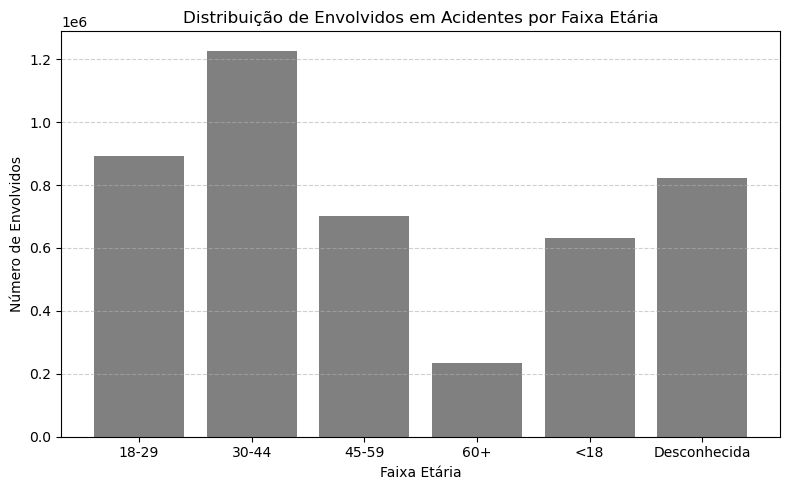

[METRIC] Tempo de execução (Distribuição por Faixa Etária): 15.66 segundos


In [3]:
from utils.workload import Workload
from pyspark.sql.functions import col, when

def analise_faixa_etaria(df):
    import matplotlib.pyplot as plt

    # Cria coluna de faixa etária
    df = df.withColumn(
        "faixa_etaria",
        when(col("idade") < 18, "<18")
        .when((col("idade") >= 18) & (col("idade") < 30), "18-29")
        .when((col("idade") >= 30) & (col("idade") < 45), "30-44")
        .when((col("idade") >= 45) & (col("idade") < 60), "45-59")
        .when(col("idade") >= 60, "60+")
        .otherwise("Desconhecida")
    )

    # Agrupa por faixa etária
    resultado = df.groupBy("faixa_etaria").count().orderBy("faixa_etaria").toPandas()
    # Verificação
    total_grafico = resultado["count"].sum()
    total_pessoas = df.select("pesid").count()
    print(f"[VERIFICAÇÃO] Total no gráfico: {total_grafico}")
    print(f"[VERIFICAÇÃO] Total de pessoas: {total_pessoas}")
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(resultado["faixa_etaria"], resultado["count"], color='gray')
    plt.xlabel("Faixa Etária")
    plt.ylabel("Número de Envolvidos")
    plt.title("Distribuição de Envolvidos em Acidentes por Faixa Etária")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Criação da workload
workload_faixa_etaria = Workload(
    name="Distribuição por Faixa Etária",
    description="[WORKLOAD-4] Analisa o número de envolvidos em acidentes por faixa etária",
    execute_fn=analise_faixa_etaria
)

# Execução da workload
workload_faixa_etaria.run(df_pessoas)

[WORKLOAD-5] Analisa o número de envolvidos em acidentes por gênero (Distribuição de Envolvidos em Acidentes por Gênero)
[VERIFICAÇÃO] Total no gráfico: 4510068
[VERIFICAÇÃO] Total de pessoas: 4510068


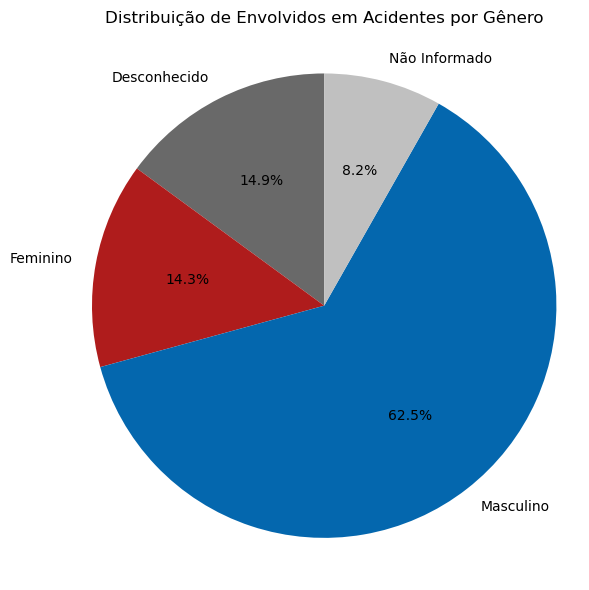

[METRIC] Tempo de execução (Distribuição de Envolvidos em Acidentes por Gênero): 12.19 segundos


In [4]:
from utils.workload import Workload
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt

def analise_distribuição_genero(df):

    df = df.withColumn(
        "sexo",
        when(col("sexo").isin("Masculino", "M"), "Masculino")
        .when(col("sexo").isin("Feminino", "F"), "Feminino")
        .when(col("sexo").isin("0", "NA", "Não Informado", "Inválido", "", None, "-1"), "Não Informado")
        .otherwise("Desconhecido")
    )

    # Agrupa por sexo
    resultado = df.groupBy("sexo").count().orderBy("sexo").toPandas()

    # Verificação
    total_grafico = resultado["count"].sum()
    total_pessoas = df.select("pesid").count()
    print(f"[VERIFICAÇÃO] Total no gráfico: {total_grafico}")
    print(f"[VERIFICAÇÃO] Total de pessoas: {total_pessoas}")

    cores_personalizadas = {
        "Masculino": "#0467ae",       # Azul
        "Feminino": "#af1c1c",        # Vermelho
        "Não Informado": "#c0c0c0",   # Cinza claro
        "Desconhecido": "#696969"     # Cinza escuro
    }
    
    # Garante que a ordem dos rótulos siga a ordem correta das cores
    labels_ordenadas = resultado["sexo"].tolist()
    cores_ordenadas = [cores_personalizadas.get(label, "#999999") for label in labels_ordenadas]
    
    plt.figure(figsize=(6, 6))
    plt.pie(
        resultado["count"],
        labels=labels_ordenadas,
        autopct="%1.1f%%",
        startangle=90,
        colors=cores_ordenadas
    )
    plt.title("Distribuição de Envolvidos em Acidentes por Gênero")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

# Criação da workload
workload_genero = Workload(
    name="Distribuição de Envolvidos em Acidentes por Gênero",
    description="[WORKLOAD-5] Analisa o número de envolvidos em acidentes por gênero",
    execute_fn=analise_distribuição_genero
)

# Execução da workload
workload_genero.run(df_pessoas)

### Análise Temporal de Acidentes: Distribuição por Hora do Dia

A análise de distribuição de acidentes por hora do dia tem como objetivo identificar a frequência com que os acidentes de trânsito ocorrem ao longo das 24 horas do dia. Esta análise é realizada com base no campo `horario` presente na base de dados consolidada de acidentes, que inclui registros de diversos anos.

Para isso, foi definida uma carga de trabalho (`Workload`) que utiliza PySpark para realizar a transformação dos dados, extraindo a hora de cada ocorrência e agrupando os registros por esse valor. O número de acidentes por hora é então contado e ordenado para facilitar a interpretação.

Após a etapa de processamento, os resultados são convertidos para um DataFrame pandas, permitindo a geração de um gráfico de barras com a biblioteca Matplotlib. Esse gráfico ilustra visualmente como os acidentes se distribuem ao longo do dia, possibilitando a identificação de faixas horárias com maior ou menor incidência de ocorrências.

In [5]:
from pyspark.sql.functions import hour, col, count, year
import matplotlib.pyplot as plt
import pandas as pd

def analise_distribuicao_temporal(df, tipo="hora"):
    """
    Realiza a análise da distribuição temporal de acidentes de trânsito,
    permitindo agrupar os dados por hora do dia, dia da semana ou ano.

    Parâmetros:
    - df (DataFrame): DataFrame contendo os dados de ocorrências.
    - tipo (str): Tipo de agrupamento temporal. Pode ser 'hora', 'semana' ou 'ano'.
    """

    if tipo == "hora":
        df_temp = df.withColumn("tempo", hour("horario"))
        titulo = "Distribuição Temporal de Acidentes por Hora do Dia"
        eixo_x = "Hora"
    elif tipo == "semana":
        df_temp = df.withColumn("tempo", col("dia_semana"))
        titulo = "Distribuição Temporal de Acidentes por Dia da Semana"
        eixo_x = "Dia da Semana"
    elif tipo == "ano":
        df_temp = df.withColumn("tempo", year(col("data_inversa")))
        titulo = "Distribuição Temporal de Acidentes por Ano"
        eixo_x = "Ano"
    else:
        raise ValueError("O parâmetro 'tipo' deve ser 'hora', 'semana' ou 'ano'.")

    # Agrupa e converte para pandas
    resultado = df_temp.groupBy("tempo").agg(count("*").alias("total")).orderBy("tempo").toPandas()

    # Ordenação dos dias da semana, se necessário
    if tipo == "semana":
        ordem_dias = [
            "segunda-feira", "terça-feira", "quarta-feira",
            "quinta-feira", "sexta-feira", "sábado", "domingo"
        ]
        resultado["tempo"] = pd.Categorical(resultado["tempo"], categories=ordem_dias, ordered=True)
        resultado = resultado.sort_values("tempo")

    # Geração do gráfico
    plt.figure(figsize=(9, 5))
    plt.bar(resultado["tempo"], resultado["total"], color="gray")
    plt.xlabel(eixo_x)
    plt.ylabel("Número de Acidentes")
    plt.title(titulo)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    if tipo == "ano":
        plt.xticks(resultado["tempo"][::1], rotation=45)
    plt.tight_layout()
    plt.show()

[WORKLOAD-6] Análise Temporal de Acidentes: Distribuição por Hora do Dia (Distribuição Temporal de Acidentes por Hora do Dia)


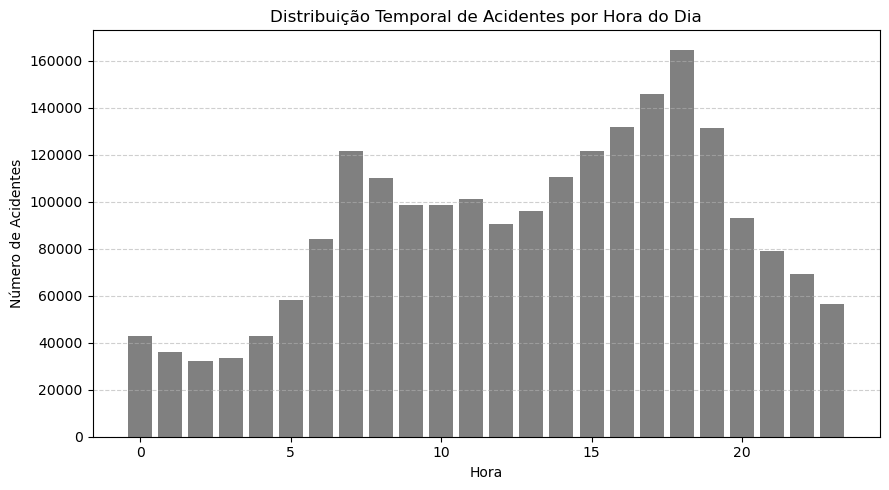

[METRIC] Tempo de execução (Distribuição Temporal de Acidentes por Hora do Dia): 2.84 segundos


In [6]:
from utils.workload import Workload

# Cria uma workload para distribuição por hora
workload_temporal_hora = Workload(
    name="Distribuição Temporal de Acidentes por Hora do Dia",
    description="[WORKLOAD-6] Análise Temporal de Acidentes: Distribuição por Hora do Dia",
    execute_fn=lambda df: analise_distribuicao_temporal(df, tipo="hora")
)

workload_temporal_hora.run(df_ocorrencias)

[WORKLOAD-7] Análise Temporal de Acidentes: Distribuição por Dia da Semana (Distribuição Temporal de Acidentes por Dia da Semana)


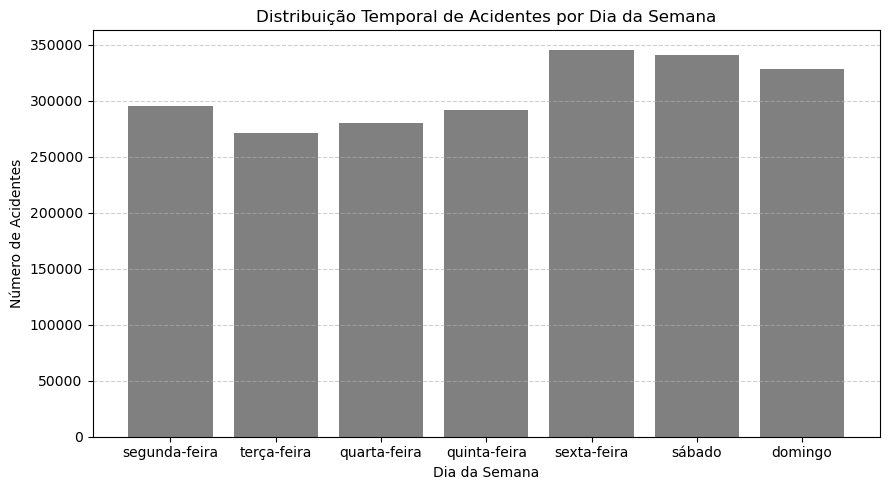

[METRIC] Tempo de execução (Distribuição Temporal de Acidentes por Dia da Semana): 2.45 segundos


In [7]:
from utils.workload import Workload

# Cria uma workload para distribuição por dia da semana
workload_temporal_hora = Workload(
    name="Distribuição Temporal de Acidentes por Dia da Semana",
    description="[WORKLOAD-7] Análise Temporal de Acidentes: Distribuição por Dia da Semana",
    execute_fn=lambda df: analise_distribuicao_temporal(df, tipo="semana")
)

workload_temporal_hora.run(df_ocorrencias)

[WORKLOAD-8] Análise Temporal de Acidentes: Distribuição por Ano (Distribuição Temporal de Acidentes por Ano)


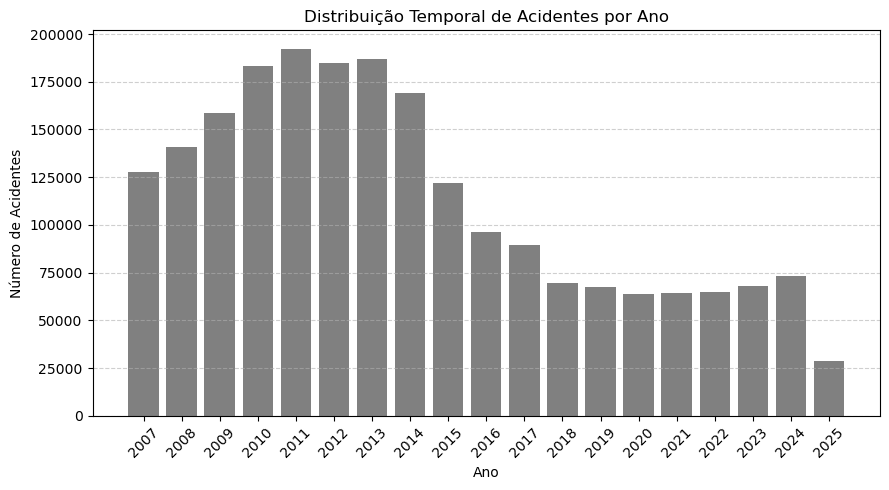

[METRIC] Tempo de execução (Distribuição Temporal de Acidentes por Ano): 2.45 segundos


In [8]:
from utils.workload import Workload

# Cria uma workload para distribuição por ano
workload_temporal_hora = Workload(
    name="Distribuição Temporal de Acidentes por Ano",
    description="[WORKLOAD-8] Análise Temporal de Acidentes: Distribuição por Ano",
    execute_fn=lambda df: analise_distribuicao_temporal(df, tipo="ano")
)

workload_temporal_hora.run(df_ocorrencias)